In this notebook I implement a classical 1D self organising map to cluster some colours

I write the SOM algorithm from scratch by following the example in [ai-junkie's](#http://www.ai-junkie.com/ann/som/som1.html) blog post about it. 

After writing the classical 2D SOM exampe I modify the algoithm to inlude some 1D wrapping. Using this I thought I should be able to recreate the colour wheel (assuming that the colour wheel really does have some ordering in RGB values and that it is not just a perception based ordering). I thought this would be a good exercise since if applying this technique to each based systems we are going to have wrapping of coordinates as well - alhtough I suppose thinking this way is mixing up the ideas of wrapping in real space and wrapping in the SOM space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here I create and look at some colour data. Each pixel has three coordinates of RGB value.

I don't just draw a random sample because I foud this gave less pretty (although still valid results). I instead constrain the colours to make them of a similar brightness - although this normalising routine was only stuck together and could be done much better. It does however, give me the kind of sample I want


In [54]:
def constant_brightness_colour_sample1(level, N):
    '''Here I randomly draw some RGB values which are roughly similar brigghtnesses'''
    colour_data = np.random.randint(10,255,size=(*N,3))
    brightness = colour_data.sum(axis=2)/(255.*3)
    correction_factor = brightness**-1 * level
    colour_data = colour_data*correction_factor[:,:,np.newaxis]
    return np.clip(np.round(colour_data).astype(int), 0, 255)

def constant_brightness_colour_sample2(level, N):
    '''Here I randomly draw some RGB values which are roughly similar brightnesses'''
    colour_data = np.zeros((*N,3))
    for i in range(N[0]):
        for j in range(N[1]):
            c1 = np.random.randint(0,min(256, level))
            c2 = np.random.randint(0,min(256, max(level-c1,0)))
            c3 = min(level-c1-c2, 255)
            cs = [c1,c2,c3]
            np.random.shuffle(cs) # this is inplace shuffle
            colour_data[i,j] = cs
    return colour_data.astype(int)

In [139]:
N=(100,100) # number of data points. Put into square to make it plot nice
level=0.6
colour_data = constant_brightness_colour_sample1(level, N)

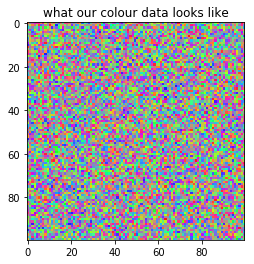

In [140]:
plt.figure()
plt.title('what our colour data looks like')
plt.imshow(colour_data)
plt.show()

we flatten the data here so we can work with more easily. Also apply scaling.

In [141]:
X = colour_data.reshape(np.product(colour_data.shape[0:2]),colour_data.shape[-1])/255.

We initiate some random weights in the map to start with

In [60]:
node_layout2D = (40,40)
W2D = np.random.random(size=(*node_layout2D, 3))

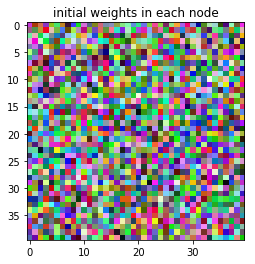

In [61]:
plt.figure()
plt.title('initial weights in each node')
plt.imshow(np.round(W2D*255).astype(int))
plt.show()

In [65]:
def sigma(sigma_0, t, lam):
    '''decay constant for affected radius'''
    return sigma_0*np.exp(-t/float(lam))

def LR(L_0, t, lam):
    '''learning rate at time step t'''
    return L_0*np.exp(-t/float(lam))

In [66]:
def single_update(W, x, i, sigma_0, lam, L_0, all_i, all_j):
    '''Apply one step of the SOM algorithm'''
    nearest_ind = np.unravel_index(((W - x)**2).sum(axis=2).argmin(), W.shape[:2])
    nodes_dist = np.sqrt((all_i - nearest_ind[0])**2 + (all_j - nearest_ind[1])**2)
    nearest_ind = np.unravel_index(((W - x)**2).sum(axis=2).argmin(), W.shape[:2])
    nodes_sqr_dist = (all_i - nearest_ind[0])**2 + (all_j - nearest_ind[1])**2
    nodes_dist = np.sqrt(nodes_sqr_dist)

    sig = sigma(sigma_0, i, lam)
    L = LR(L_0, i, lam)
    theta = np.exp(-nodes_sqr_dist/(2*sig**2))

    W[nodes_dist<=sig] = \
                        W[nodes_dist<=sig] \
                        + (-W[nodes_dist<=sig]+x)*L*theta[nodes_dist<=sig, np.newaxis]
    return W

def SOM(X, W, M, L_0):
    '''apply M steps of the SOM algorithm'''
    new_weights = W.copy()
    sigma_0 = max(W.shape)/2.
    lam = M/np.log(sigma_0)
    
    all_i = np.zeros(W.shape[:2]) + np.arange(W.shape[0])[:, np.newaxis]
    all_j = np.zeros(W.shape[:2]) + np.arange(W.shape[1])[np.newaxis, :]
    
    for i in range(M):
        x = X[np.random.randint(0,X.shape[0]-1,1)[0]]
        new_weights = single_update(new_weights, x, i, sigma_0, lam, L_0,  all_i, all_j)
    return new_weights
    

In [67]:
W2D_solved = SOM(X, W2D, 1000, 0.1)

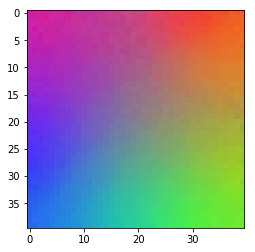

In [68]:
plt.imshow(np.round(W2D_solved*255).astype(int))
plt.show()

# Now lets try it again in 1D

In [261]:
node_layout1D = (1,10)
W1D = np.random.random(size=(*node_layout1D, 3))

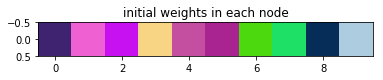

In [262]:
plt.figure()
plt.title('initial weights in each node')
plt.imshow(np.round(W1D*255).astype(int))
plt.show()

In [281]:
W1D_solved = SOM(X, W1D, 1000, 0.1)

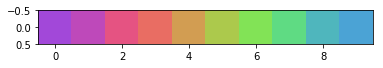

In [282]:
plt.imshow(np.round(W1D_solved*255).astype(int))
plt.show()

# Lets try it with wrapping in 2D

In [283]:
def loop_dist(flat_dist, N):
    return (flat_dist<=N/2)*flat_dist + (flat_dist>(N/2)) * (N/2-(flat_dist%(N/2)))

def wrapped_sqr_distance(xy, w, h):
    distance = np.zeros((w,h))
    x_dist = np.abs(distance + np.arange(w)[:, np.newaxis] - xy[0])
    y_dist = np.abs(distance + np.arange(h)[np.newaxis, :] - xy[0])
    # now make the modification for the toroid shape
    x_dist = loop_dist(x_dist, w) if w!=1 else 0
    y_dist = loop_dist(y_dist, h) if h!=1 else 0
    return x_dist**2 + y_dist**2

def single_update_wrapping(W, x, i, sigma_0, lam, L_0, all_i, all_j):
    '''Apply one step of the SOM algorithm'''
    nearest_ind = np.unravel_index(((W - x)**2).sum(axis=2).argmin(), W.shape[:2])
    nodes_sqr_dist = wrapped_sqr_distance(nearest_ind, *W.shape[:2])
    nodes_dist = np.sqrt(nodes_sqr_dist)

    sig = sigma(sigma_0, i, lam)
    L = LR(L_0, i, lam)
    theta = np.exp(-nodes_sqr_dist/(2*sig**2))

    W[nodes_dist<=sig] = \
                        W[nodes_dist<=sig] \
                        + (-W[nodes_dist<=sig]+x)*L*theta[nodes_dist<=sig, np.newaxis]
    return W

def SOM_wrapping(X, W, M, L_0):
    '''apply M steps of the SOM algorithm'''
    new_weights = W.copy()
    sigma_0 = max(W.shape)/2.
    lam = M/np.log(sigma_0)
    
    all_i = np.zeros(W.shape[:2]) + np.arange(W.shape[0])[:, np.newaxis]
    all_j = np.zeros(W.shape[:2]) + np.arange(W.shape[1])[np.newaxis, :]
    
    for i in range(M):
        x = X[np.random.randint(0,X.shape[0]-1,1)[0]]
        new_weights = single_update_wrapping(new_weights, x, i, sigma_0, lam, L_0,  all_i, all_j)
    return new_weights

In [284]:
W2D_wrap_solved = SOM_wrapping(X, W2D, 1000, 0.1)

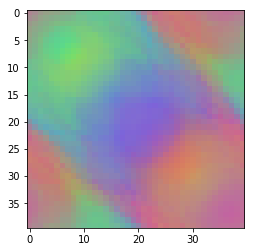

In [285]:
plt.imshow(W2D_wrap_solved)
plt.show()

Plot 9 copies of the solution 3x3 so we can see the pattern and warpping properties

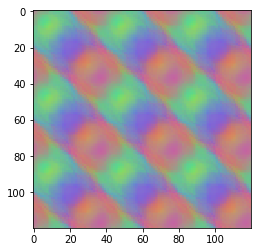

In [286]:
wrapped_im = np.tile(np.round(W2D_wrap_solved*255).astype(int),(3,3,1))
plt.imshow(wrapped_im)
plt.show()

# Finally do wrapping in 1D

In [290]:
W1D_wrap_solved = np.transpose(SOM_wrapping(X, np.transpose(W1D, axes=(1,0,2)), 1000, 0.1), axes=(1,0,2))

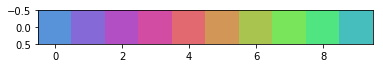

In [291]:
plt.imshow(np.round(W1D_wrap_solved*255).astype(int))
plt.show()